In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, Ridge
from scipy.stats import multivariate_normal
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()

figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('figure', **{'dpi': 300})

/home/petr/miniconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Часть 1

## 1

Прокурор неправильно оценил обе вероятности: 

* $$ \text{P(у подсудимого такая группа крови | невиновен)} = \\ = \frac{\text{P(невиновен | у подсудимого такая группа крови)}\cdot \text{P(у подсудимого такая группа крови)}}{\text{P(невиновен)}} = \\ = \frac{\text{P(невиновен | у подсудимого такая группа крови)}}{\text{P(невиновен)}} - \text{не можем точно оценить (не 1%)} $$

* $$ \text{P(виновен | у подсудимого такая группа крови)} = \\ = \frac{\text{P(у подсудимого такая группа крови | виновен)}\cdot \text{P(виновен)}}{\text{P(у подсудимого такая группа крови)}} = \\ = \text{P(виновен)} $$

Получили, что события того, что человек виновен и того, что у него особая группа крови - независимые события, значит ничего сказать о виновности подсудимого невозможно.

## 2

Первая ошибка адвоката в предположении, что в городе ровно 1% обладает такой группой крови. Могло быть такое, что все миллион человек обладают ей. Далее из этого он сделал вывод, что вероятность виновности подзащитного равна вероятности иметь эту группу крови, а как мы уже показали в пункте 1 эти вероятности независимы.

## 3

Пусть X - событие того, что человек болен, а y - показание теста на наличие болезни

Давайте уменьшим false positive

In [2]:
def make_plot(y1, y2, x, xlabel='False positive', ylabel='Proba'):
    plt.figure(figsize=(18, 7))
    plt.subplot(121)
    plt.plot(x, y1, color='red', label='P(X | y=positive)')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='center right', fontsize='x-large')
    plt.ylim((0, 1.1))
    
    plt.subplot(122)
    plt.plot(x, y2, label='P($\overline{X}$ | y=negative)')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='center right', fontsize='x-large')
    plt.ylim((0, 1.1))
    
    plt.show()

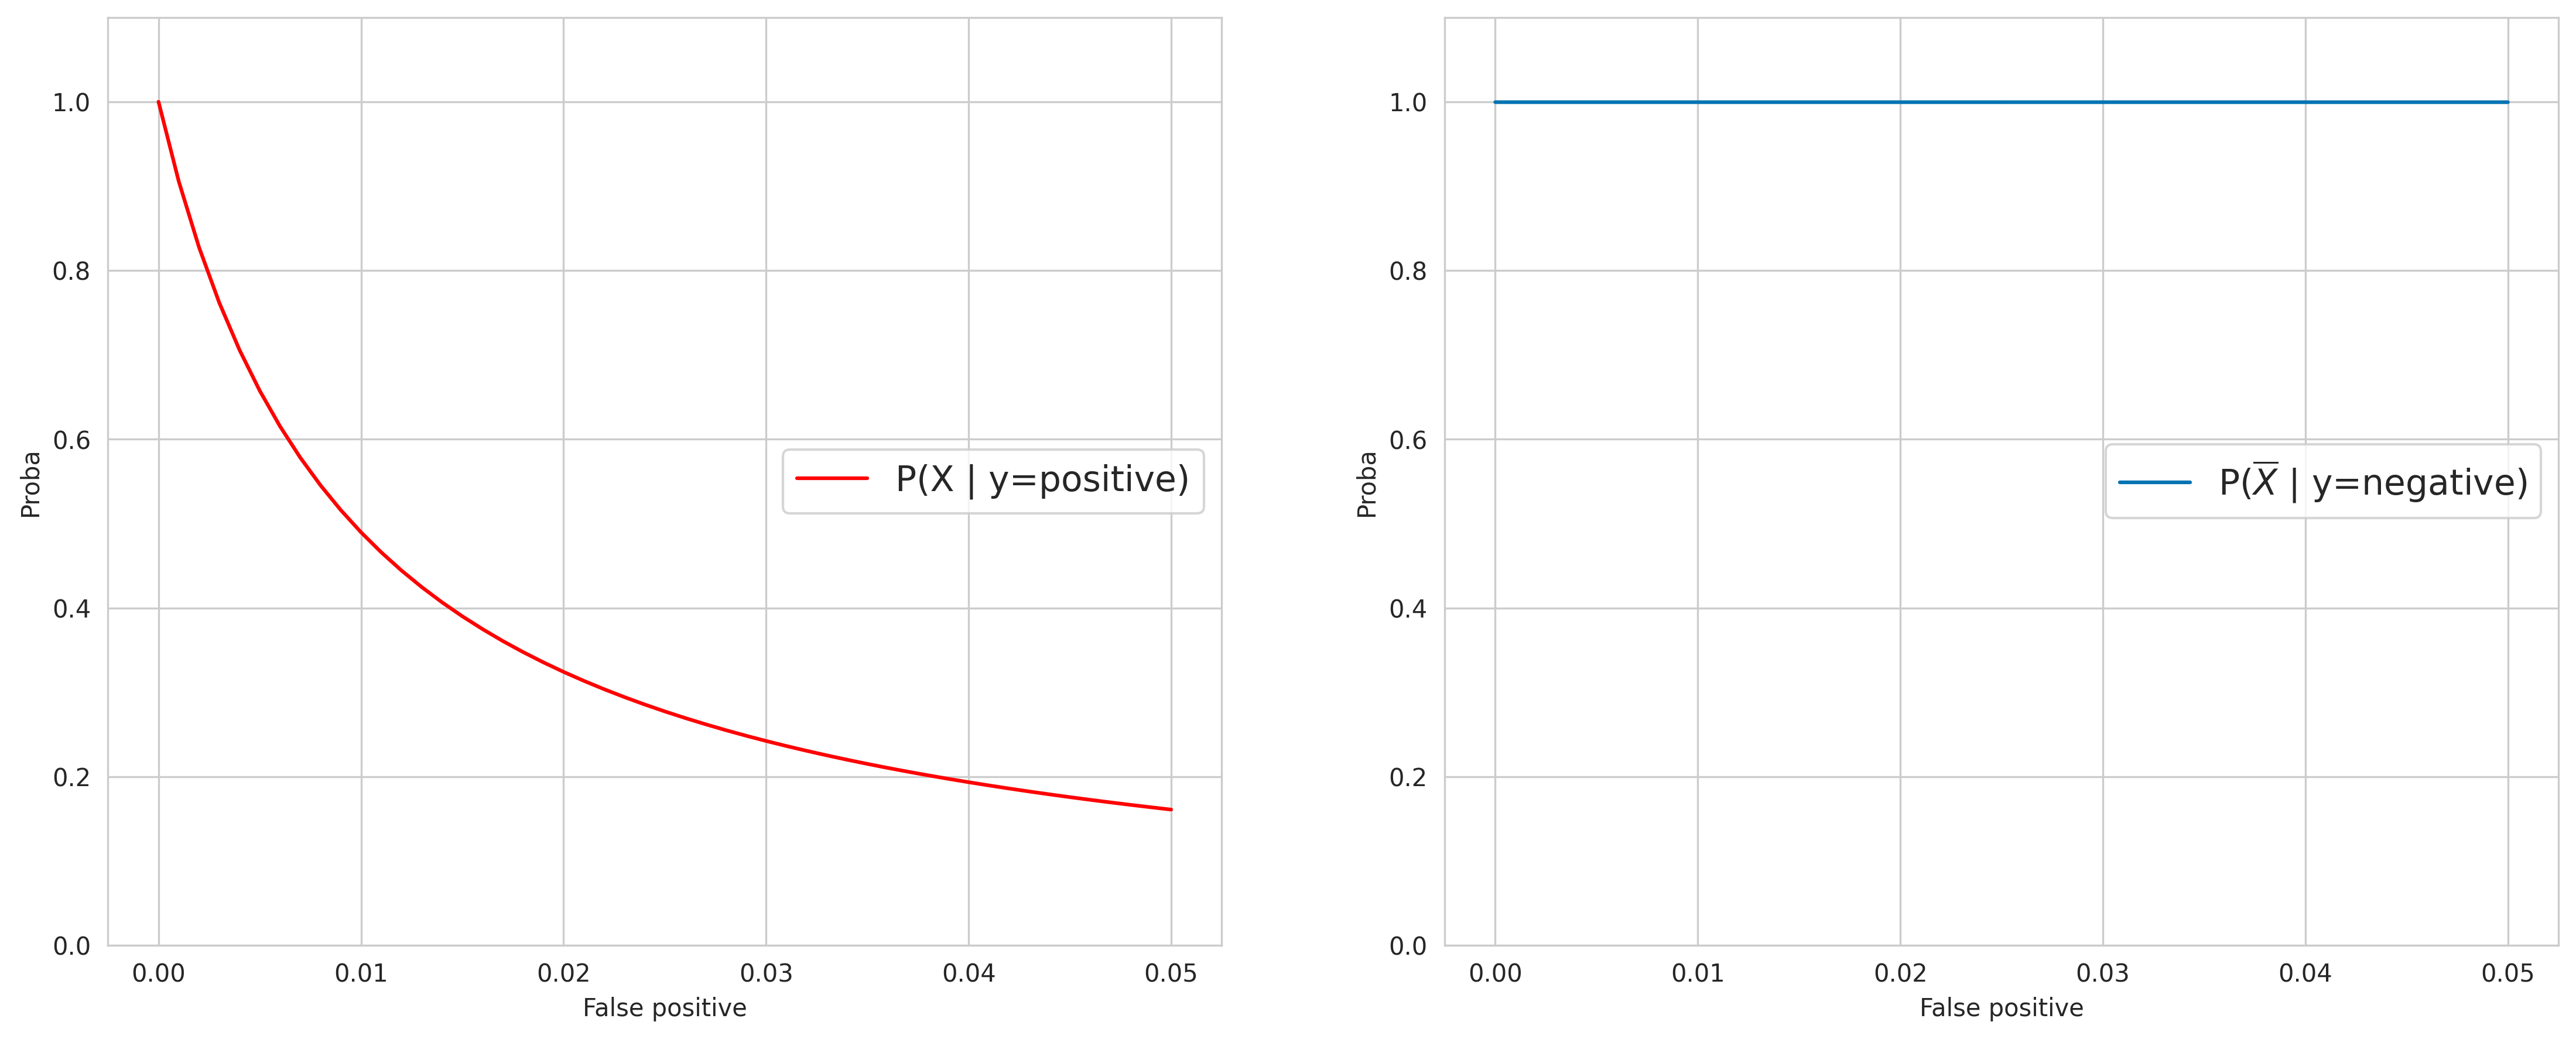

In [3]:
fp_test_proba = np.arange(0., 0.051, 0.001)
fn_test_proba = 0.05
p_ill = 0.01

tp_proba = (1 - fn_test_proba) * p_ill / (p_ill * (1 - fn_test_proba) + (1 - p_ill) * fp_test_proba)
fn_proba = (1 - fp_test_proba) * (1 - p_ill) / (p_ill * fn_test_proba + (1 - p_ill) * (1 - fp_test_proba))

make_plot(tp_proba, fn_proba, fp_test_proba, 'False positive', 'Proba')

Теперь false negative

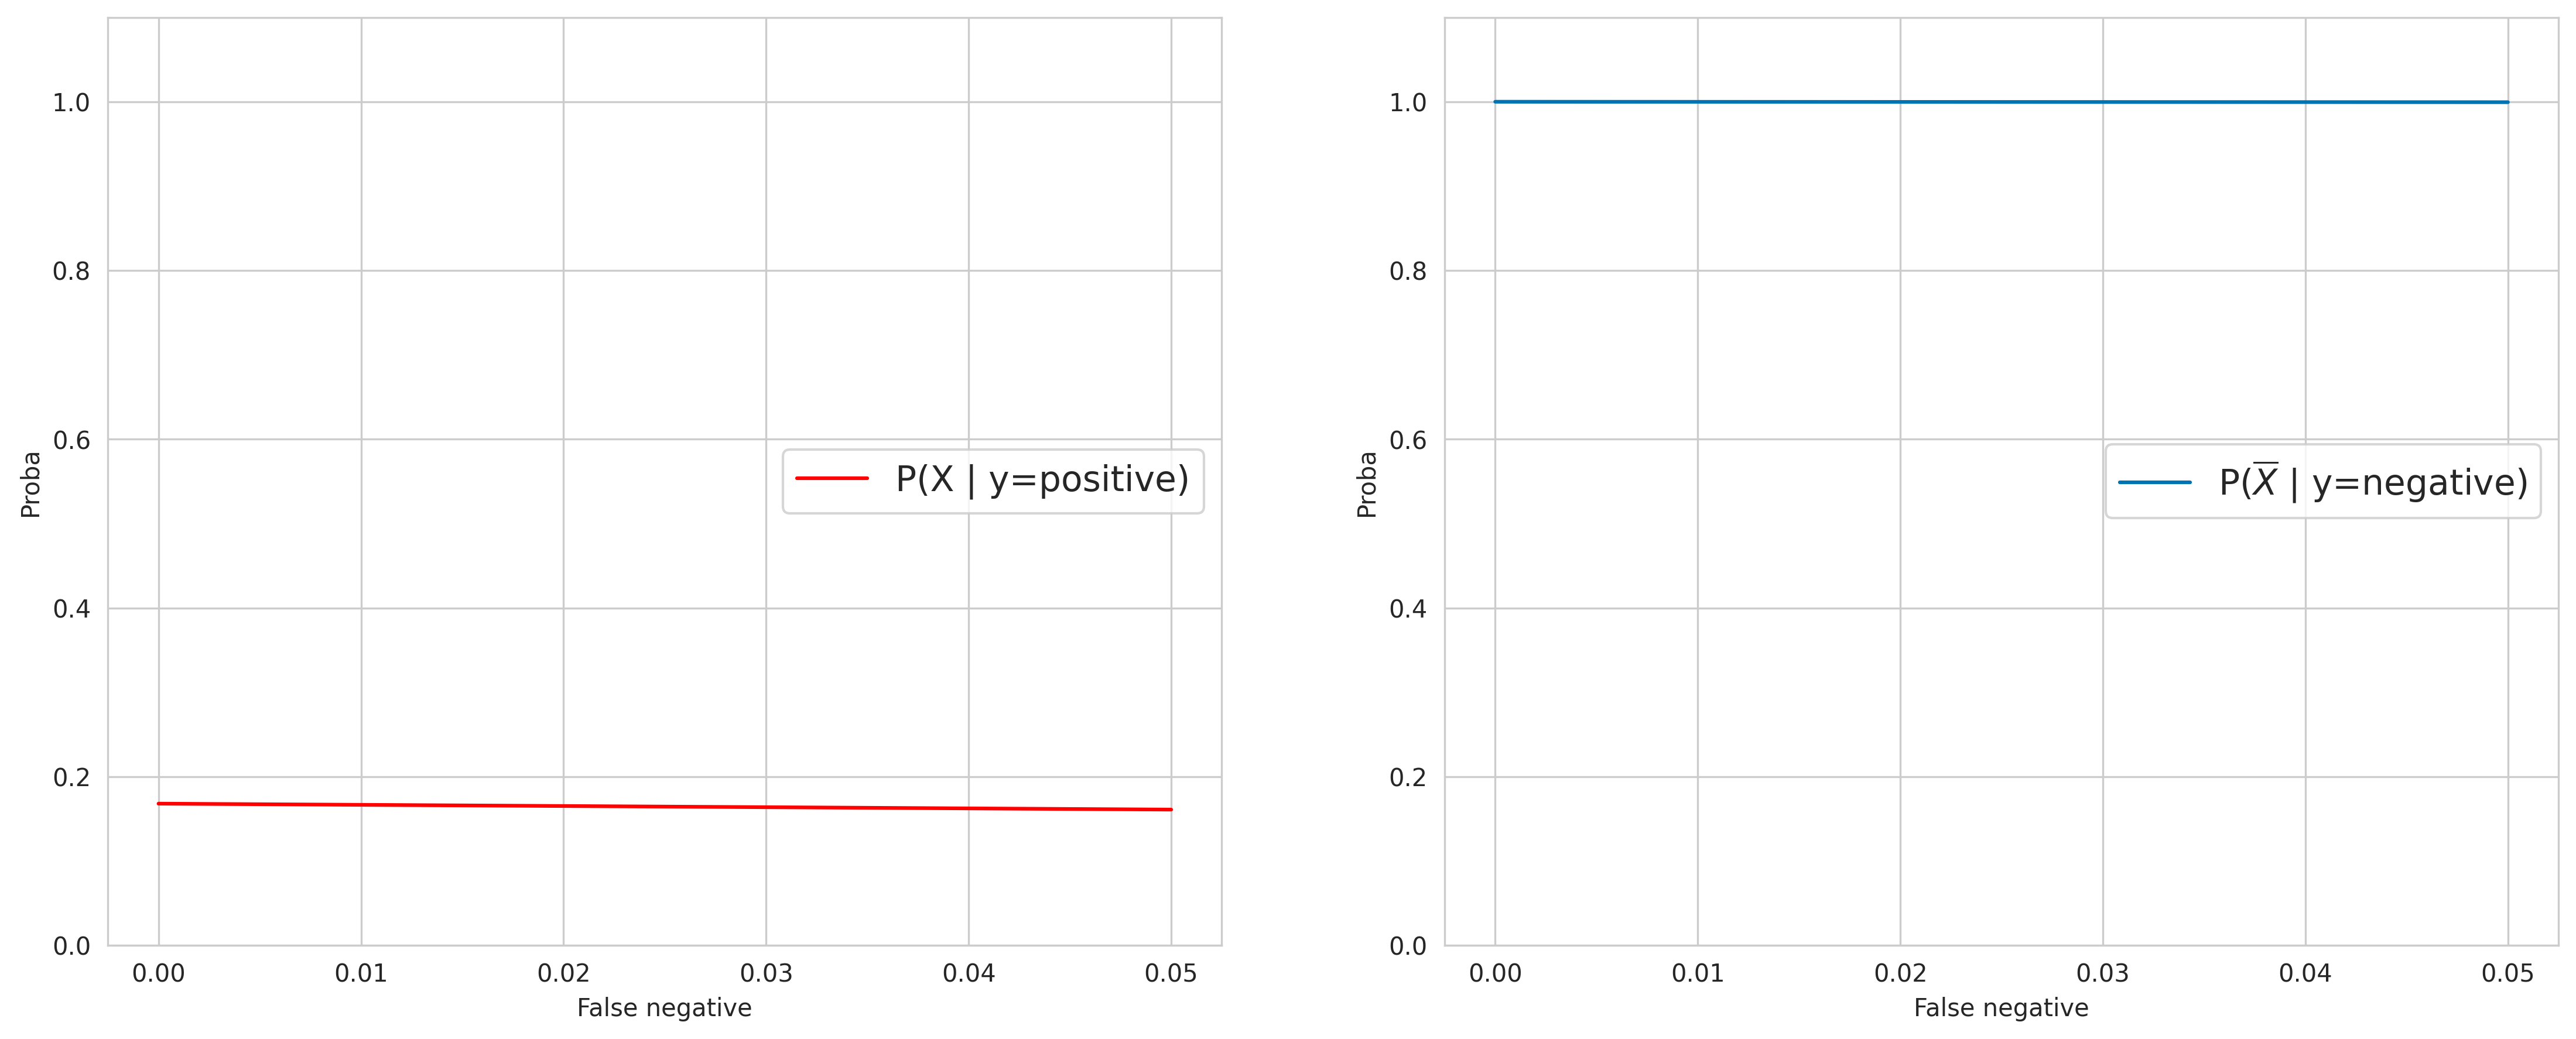

In [4]:
fp_test_proba = 0.05
fn_test_proba = np.arange(0., 0.051, 0.001)
p_ill = 0.01

tp_proba = (1 - fn_test_proba) * p_ill / (p_ill * (1 - fn_test_proba) + (1 - p_ill) * fp_test_proba)
fn_proba = (1 - fp_test_proba) * (1 - p_ill) / (p_ill * fn_test_proba + (1 - p_ill) * (1 - fp_test_proba))

make_plot(tp_proba, fn_proba, fn_test_proba, 'False negative', 'Proba')

Можем заметить, что в обоих случаях вероятность того, что человек здоров, при условии того, что он получает отрицательный тест близка к единице. Но зато есть сильное отличие в зависимости вероятностей того, что человек болен и получает положительный тест. При уменьшении false negative видим незначительный рост данной вероятности, но при уменьшении false negative - сильный рост. Из чего можем сделать вывод, что медикам стоит уменьшать именно false positive

# Часть 2

## 1

In [5]:
!wget https://covid.ourworldindata.org/data/owid-covid-data.csv

--2021-02-27 18:52:36--  https://covid.ourworldindata.org/data/owid-covid-data.csv
Resolving covid.ourworldindata.org (covid.ourworldindata.org)... 104.21.233.138, 104.21.233.137, 2606:4700:3038::6815:e98a, ...
Connecting to covid.ourworldindata.org (covid.ourworldindata.org)|104.21.233.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘owid-covid-data.csv.1’

owid-covid-data.csv     [<=>                 ]  17,39M  1,77MB/s    in 9,8s    

2021-02-27 18:52:46 (1,77 MB/s) - ‘owid-covid-data.csv.1’ saved [18237453]



In [6]:
df = pd.read_csv('owid-covid-data.csv')

In [7]:
df_rus = df[df.location == 'Russia']
df_rus['days'] = (pd.to_datetime(df_rus.date) - pd.to_datetime('2020-03-01')).dt.days
df_rus['new_cases'] = df_rus.pop('new_cases').apply(lambda x: max(1., x))
df_rus = df_rus.loc[:, ['days', 'total_cases', 'new_cases']]

<ipython-input-7-f8cc3ea279d5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rus['days'] = (pd.to_datetime(df_rus.date) - pd.to_datetime('2020-03-01')).dt.days
<ipython-input-7-f8cc3ea279d5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rus['new_cases'] = df_rus.pop('new_cases').apply(lambda x: max(1., x))


In [8]:
TRAIN_SIZE = 50

train = df_rus[(0 <= df_rus.days) & (df_rus.days < TRAIN_SIZE)]
test = df_rus[df_rus.days >= 0].copy()

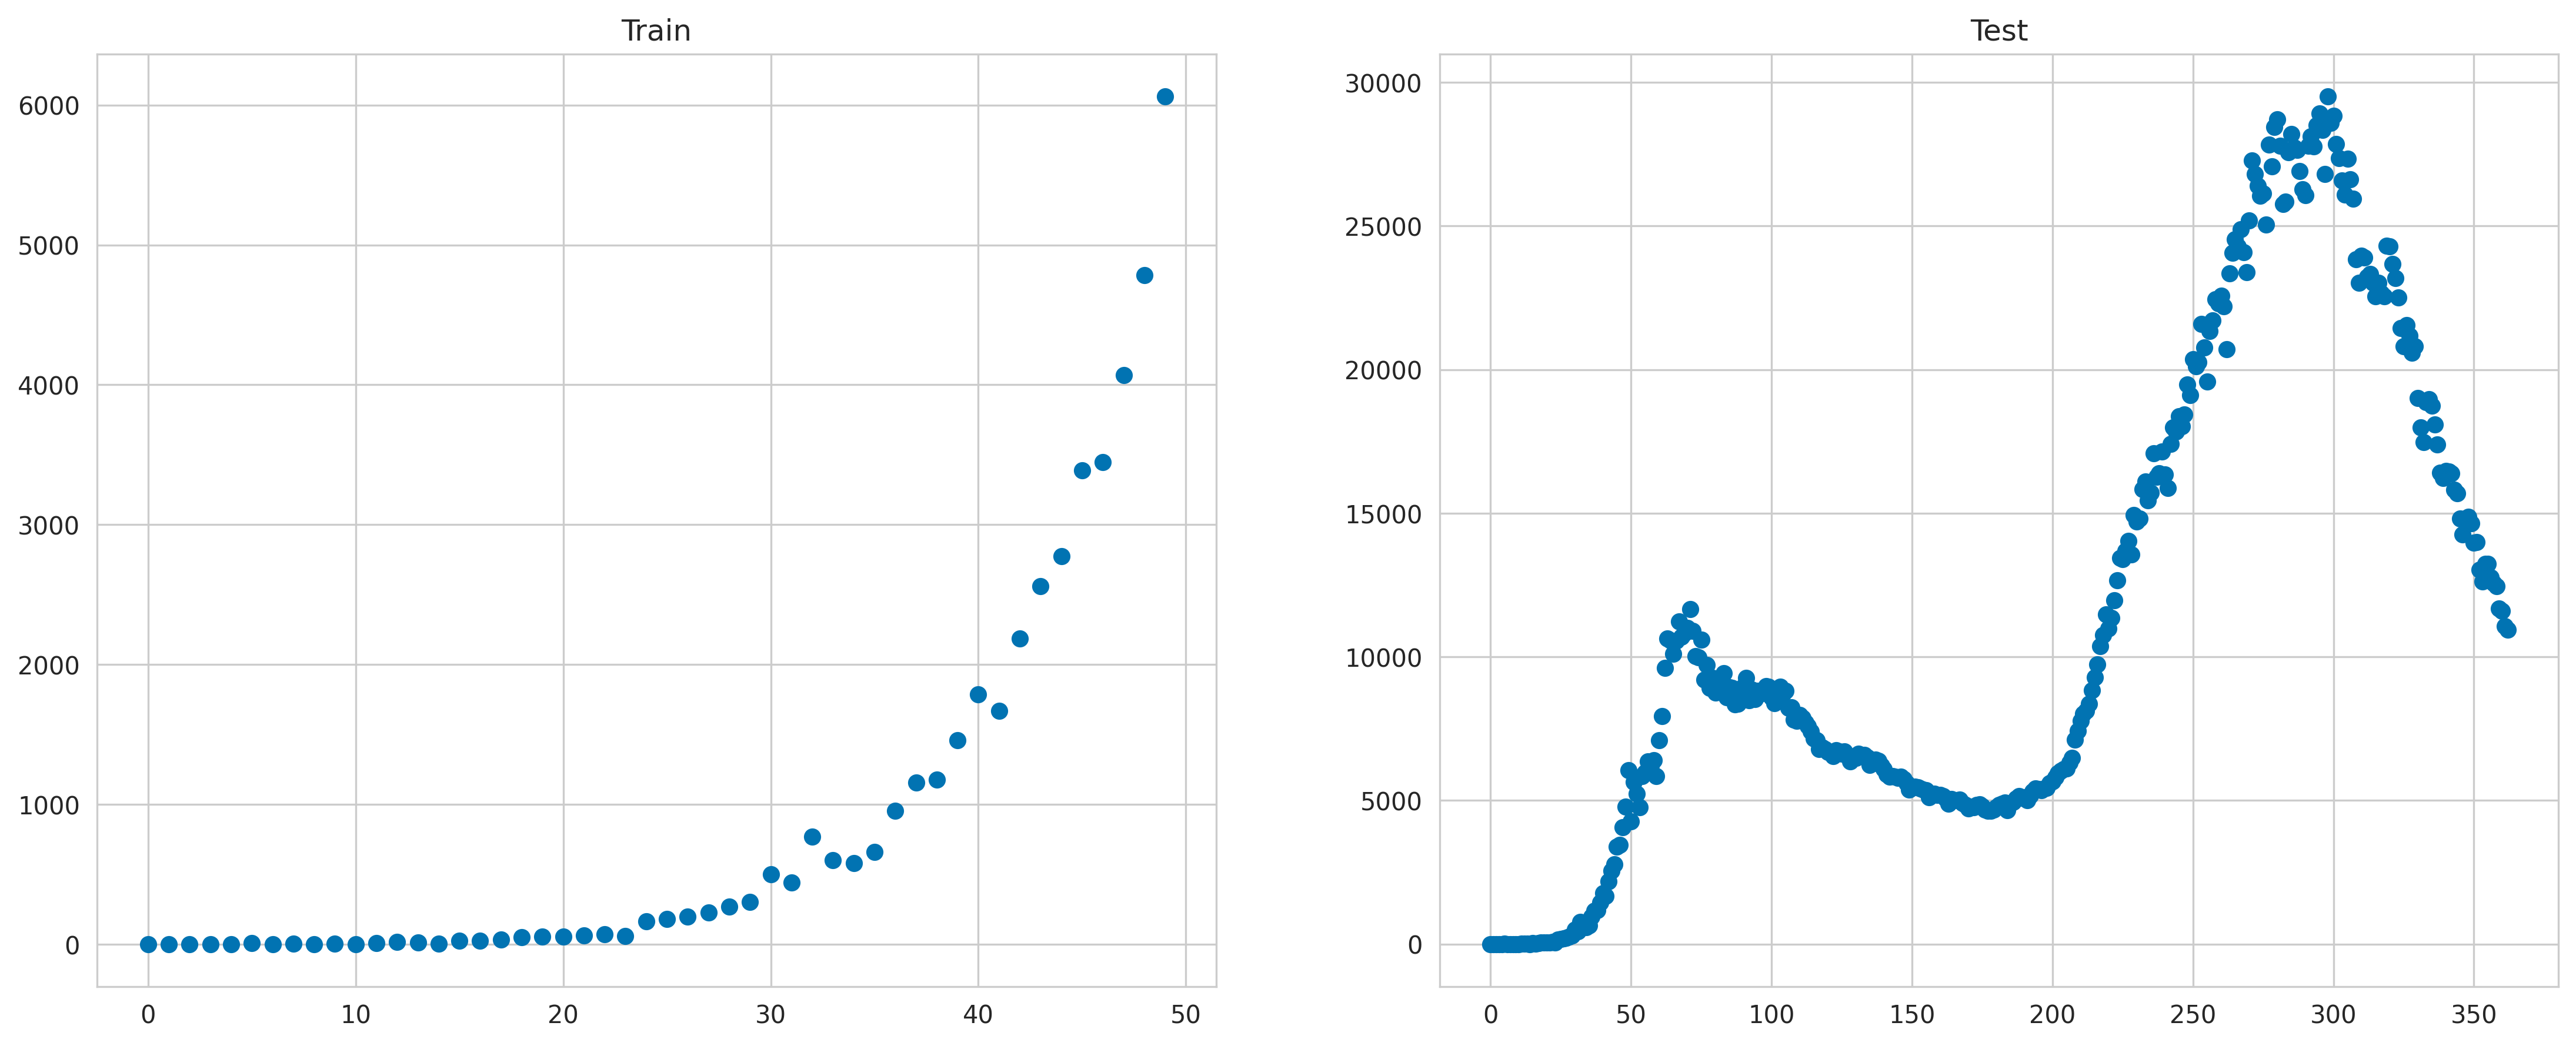

In [9]:
plt.figure(figsize=(18, 7))
plt.subplot(121)
plt.title('Train')
plt.scatter(train.days, train.new_cases)
plt.subplot(122)
plt.title('Test')
plt.scatter(test.days, test.new_cases)
plt.show()

## 2.

### a) Построим экспоненциальную модель при помощи линейной регрессии

Построим модель линейной регрессии $ \ln y = wx + b + \varepsilon $ при помощи реализации из библиотеки sklearn.

где $\varepsilon$ - ошибка из распределения $ \mathcal{N}(0, \sigma^2) $

In [10]:
new_cases_model = LinearRegression().fit(train[['days']], np.log(train['new_cases'])) #Ridge(alpha=3000)
total_cases_model = LinearRegression().fit(train[['days']], np.log(train['total_cases']))

In [11]:
test['new_cases_prediction'] = np.exp(new_cases_model.predict(test[['days']]))
test['total_cases_prediction'] = np.exp(total_cases_model.predict(test[['days']]))

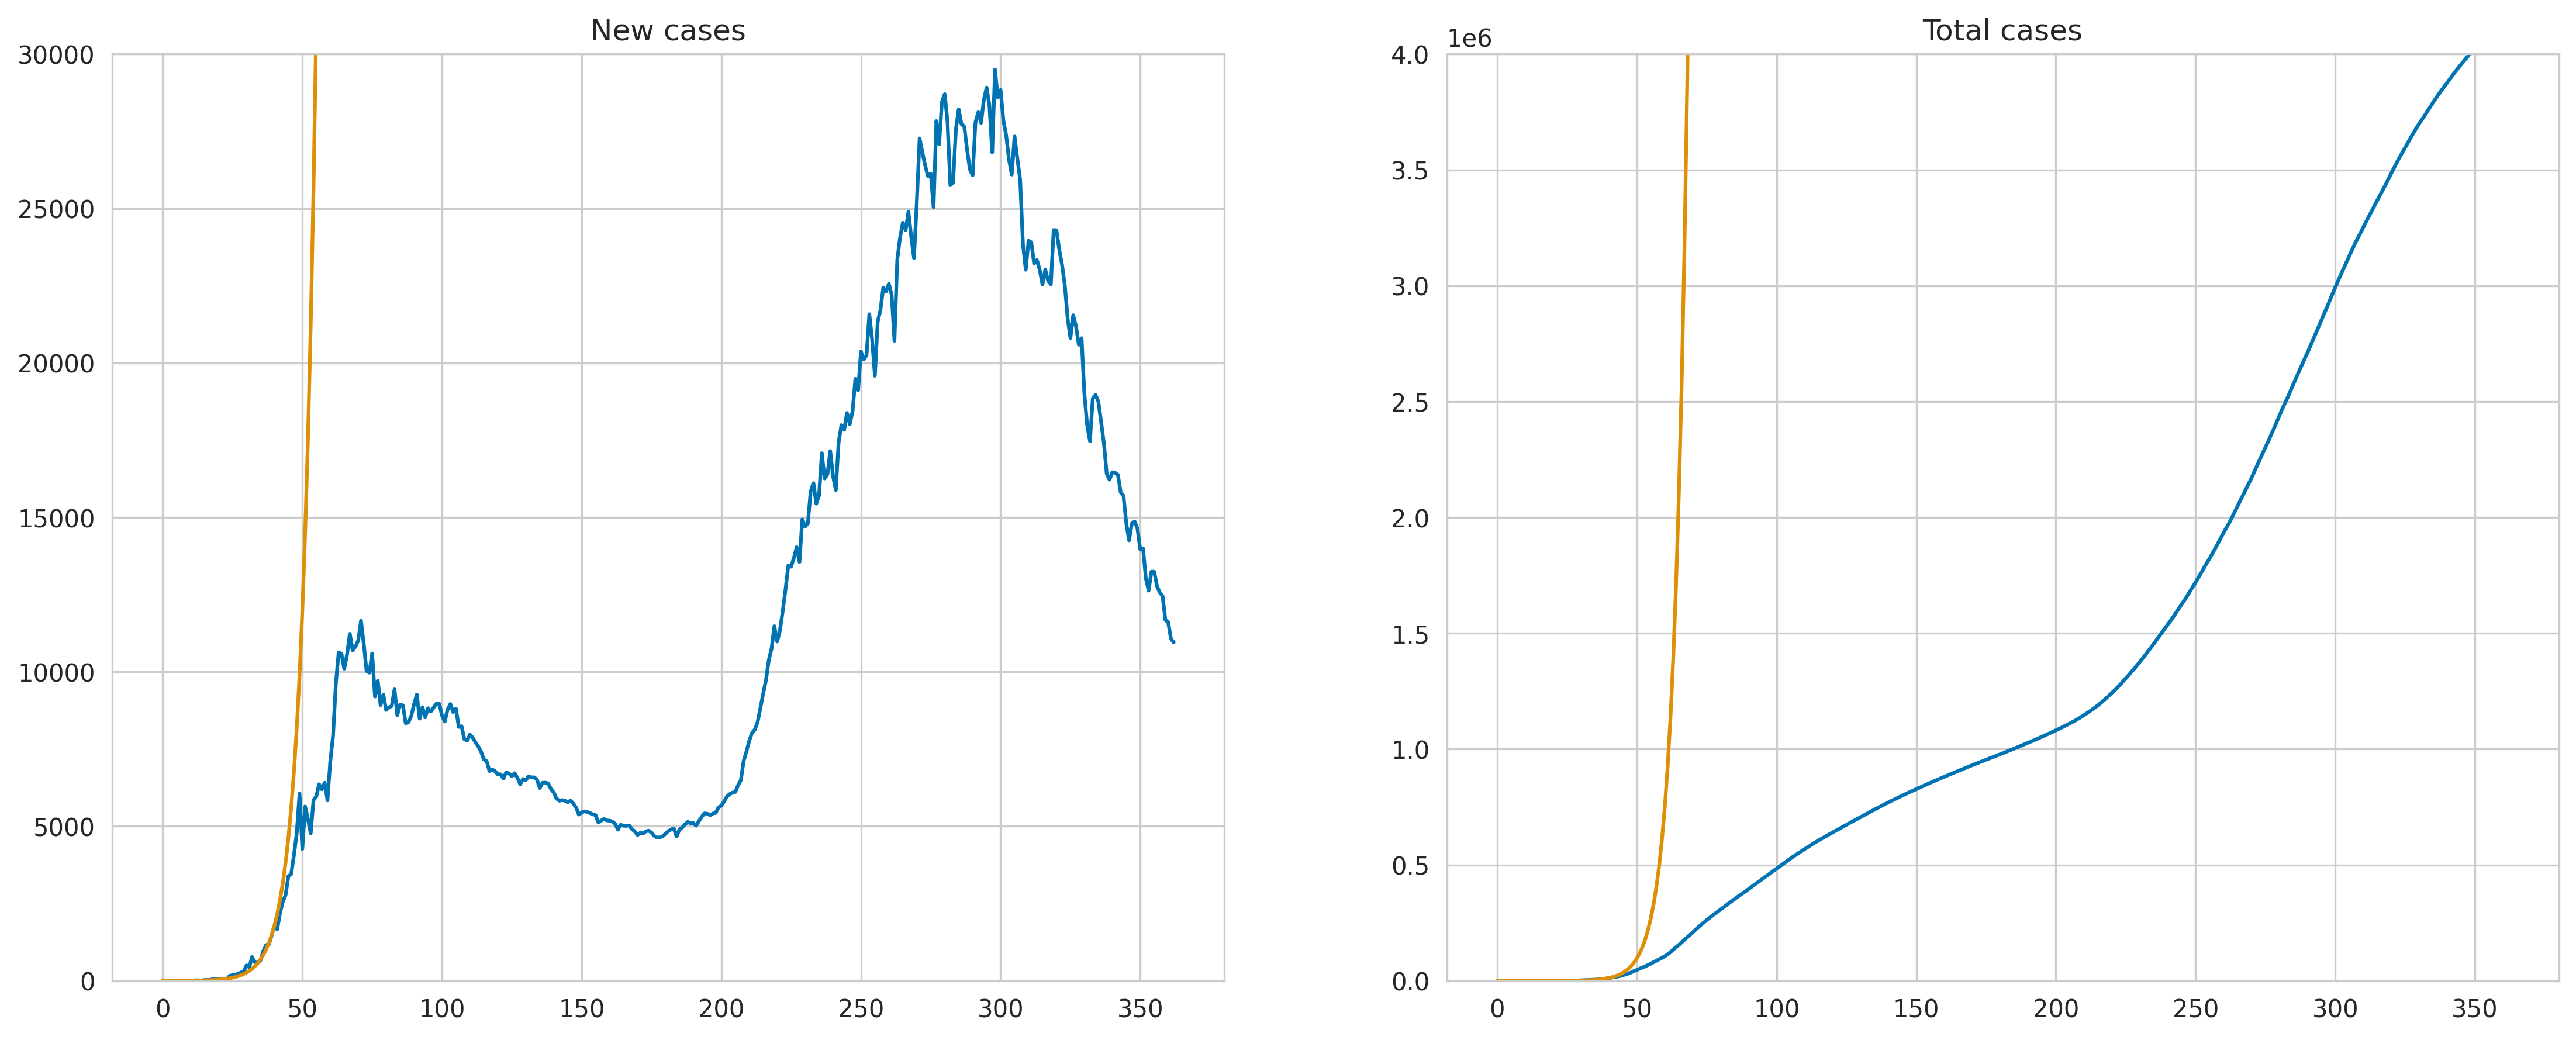

In [12]:
plt.figure(figsize=(18, 7))
plt.subplot(121)
plt.title('New cases')
plt.plot(test.days, test.new_cases)
plt.plot(test.days, test.new_cases_prediction)
plt.ylim((-2, 30000))

plt.subplot(122)
plt.title('Total cases')
plt.plot(test.days, test.total_cases)
plt.plot(test.days, test.total_cases_prediction)
plt.ylim((-2, 4e6))

plt.show()

### b) 

Теперь, используя параметры модели из предыдущего пункта и отклонение предсказаний от реальных значений, оценим значение дисперсии шума в данных и найдем апостериорное распределение

1. Определим априорное распределение, предполагая, что параметры модели распределены нормально:

$$ \theta_0 \sim \mathcal{N}\big( \begin{pmatrix} w_0 \\ b_0 \end{pmatrix}, \Sigma_0 =  \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} \big), $$

где $w_0, b_0$ - переметры нашей модели из предыдущего пункта.

2. Далее воспользуемся формулой Байеса для нахождения апостериорного распределения: $ p(\theta | \mathcal{D}) \sim p(\mathcal{D} | \theta)\cdot p(\theta) $

$$ p(\mathcal{D} | \theta) = \prod \frac{1}{\sqrt{2\pi \sigma_{MAP}^2}} \cdot \exp(-\frac{(\ln y - w^T X)^2}{2\sigma_{MAP}^2}) \\ p(\theta) = \frac{1}{\sqrt{2\pi \Sigma_0}} \cdot \exp(-\frac{1}{2} \theta_0^T \Sigma_0 \theta_0) $$

3. Новые параметры модели будут распределены нормально с параметрами (обновление происходит каждый раз после добавления новой точки в функцию правдоподобия):

$$ \Sigma_i = (\Sigma_{i-1}^{-1} + \frac{1}{\sigma_{i-1}}X^TX)^{-1} \\
\mu_i = \Sigma_{i-1}\cdot(\Sigma_{i-1}^{-1}\mu_{i-1} + \frac{1}{\sigma_{i-1}}X^Ty) $$

Оценим дисперсию шума $\sigma^2$. Для этого воспользуемся оценкой максимума правдоподобия:

$$ p(\sigma | \mathcal{D}) = \prod \frac{1}{\sqrt{2\pi \sigma^2}} \exp(- \frac{(\ln y - w^TX)^2}{2\sigma^2}) \rightarrow \max_{\sigma^2} $$

Взяв производную, получим $ \sigma_n^2 = \frac{1}{n}\sum_{i=1}^{n}(\ln y_i - wx_i - b)^2 $

Так как мы добавляем каждую новую точку итеративно, дисперсию шума будем также менять итеративно от шага к шагу. За начальную дисперсию можно взять дисперсию шума из предыдущего пункта

In [13]:
new_cases_std = np.std(np.log(test.new_cases[:TRAIN_SIZE]) - np.log(test.new_cases_prediction[:TRAIN_SIZE]))**2

In [14]:
def bayesian_update_exp(mu, sigma, x, y, sigma_noise, n):
    if n != 0:
        sigma_noise = n/(n+1) * sigma_noise + 1/(n+1) * (y - mu[0] - mu[1] * x)**2
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n,
                     np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) 
                    )
    return mu_n, sigma_n, sigma_noise

In [15]:
def sample_statistics_exp(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = np.exp(w[0] + w[1]*xs)
    return res

# Нарисуем результат
def plot_predictions_exp(xs, mu, x, label='new_cases'):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    if label == 'new_cases':
        ax.set_ylim((-2, 30000))
    else:
        ax.set_ylim((-2, 4e6))
    ax.plot(xs, test[label], label="Правильный ответ")
    ax.plot(xs, np.exp(mu[1]*xs + mu[0]), color="red", label="MAP гипотеза")
    ax.fill_between(xs, np.exp(mu[1]*xs + mu[0] - .5), np.exp(mu[1]*xs + mu[0] + .5), color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), 
                    np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend(fontsize=legend_fontsize)

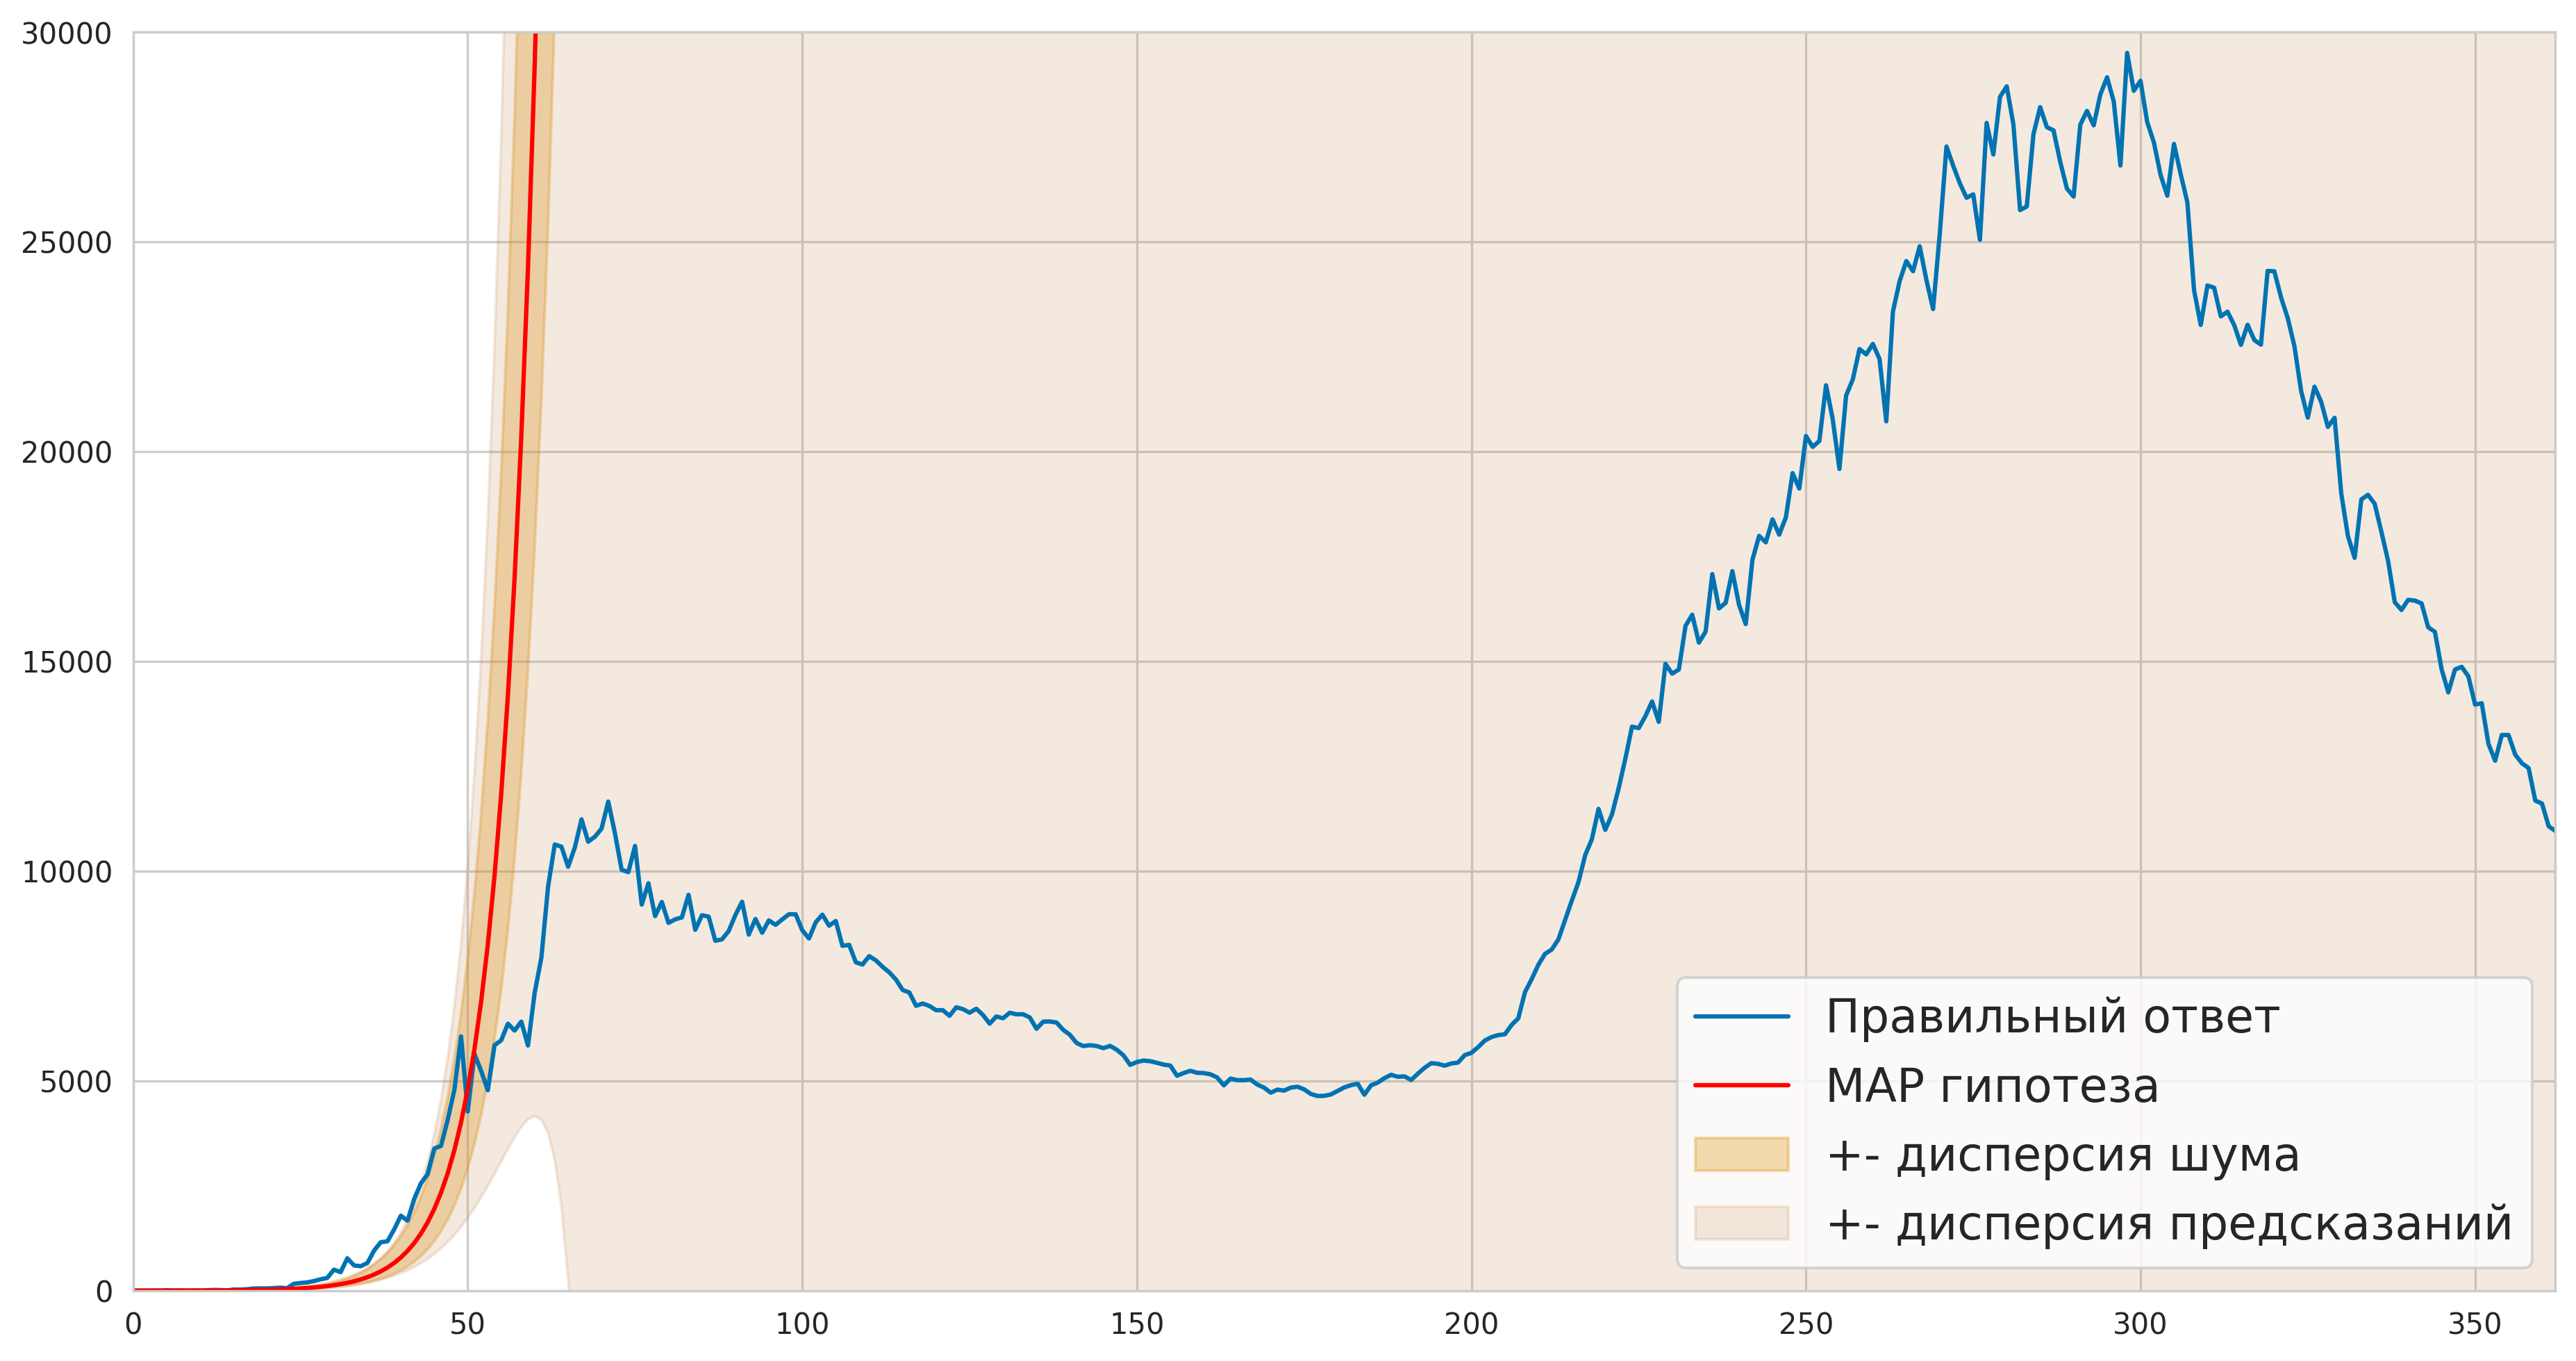

In [16]:
cur_mu_nc_exp, cur_sigma_nc_exp = np.array([new_cases_model.coef_[0], new_cases_model.intercept_]), \
                    np.array([[1, 0], [0, 1]])
for i in range(train.shape[0]):
    cur_mu_nc_exp, cur_sigma_nc_exp, new_cases_std = bayesian_update_exp(cur_mu_nc_exp, cur_sigma_nc_exp, train.days.values[i], \
                                                           np.log(train.new_cases.values[i]), new_cases_std, n=i)

x = sample_statistics_exp(cur_mu_nc_exp, cur_sigma_nc_exp, test.days.values, n=5000)
plot_predictions_exp(test.days.values, cur_mu_nc_exp, x)

In [17]:
total_cases_std = np.std(np.log(test.total_cases[:TRAIN_SIZE]) - np.log(test.total_cases_prediction[:TRAIN_SIZE]))**2 * 120

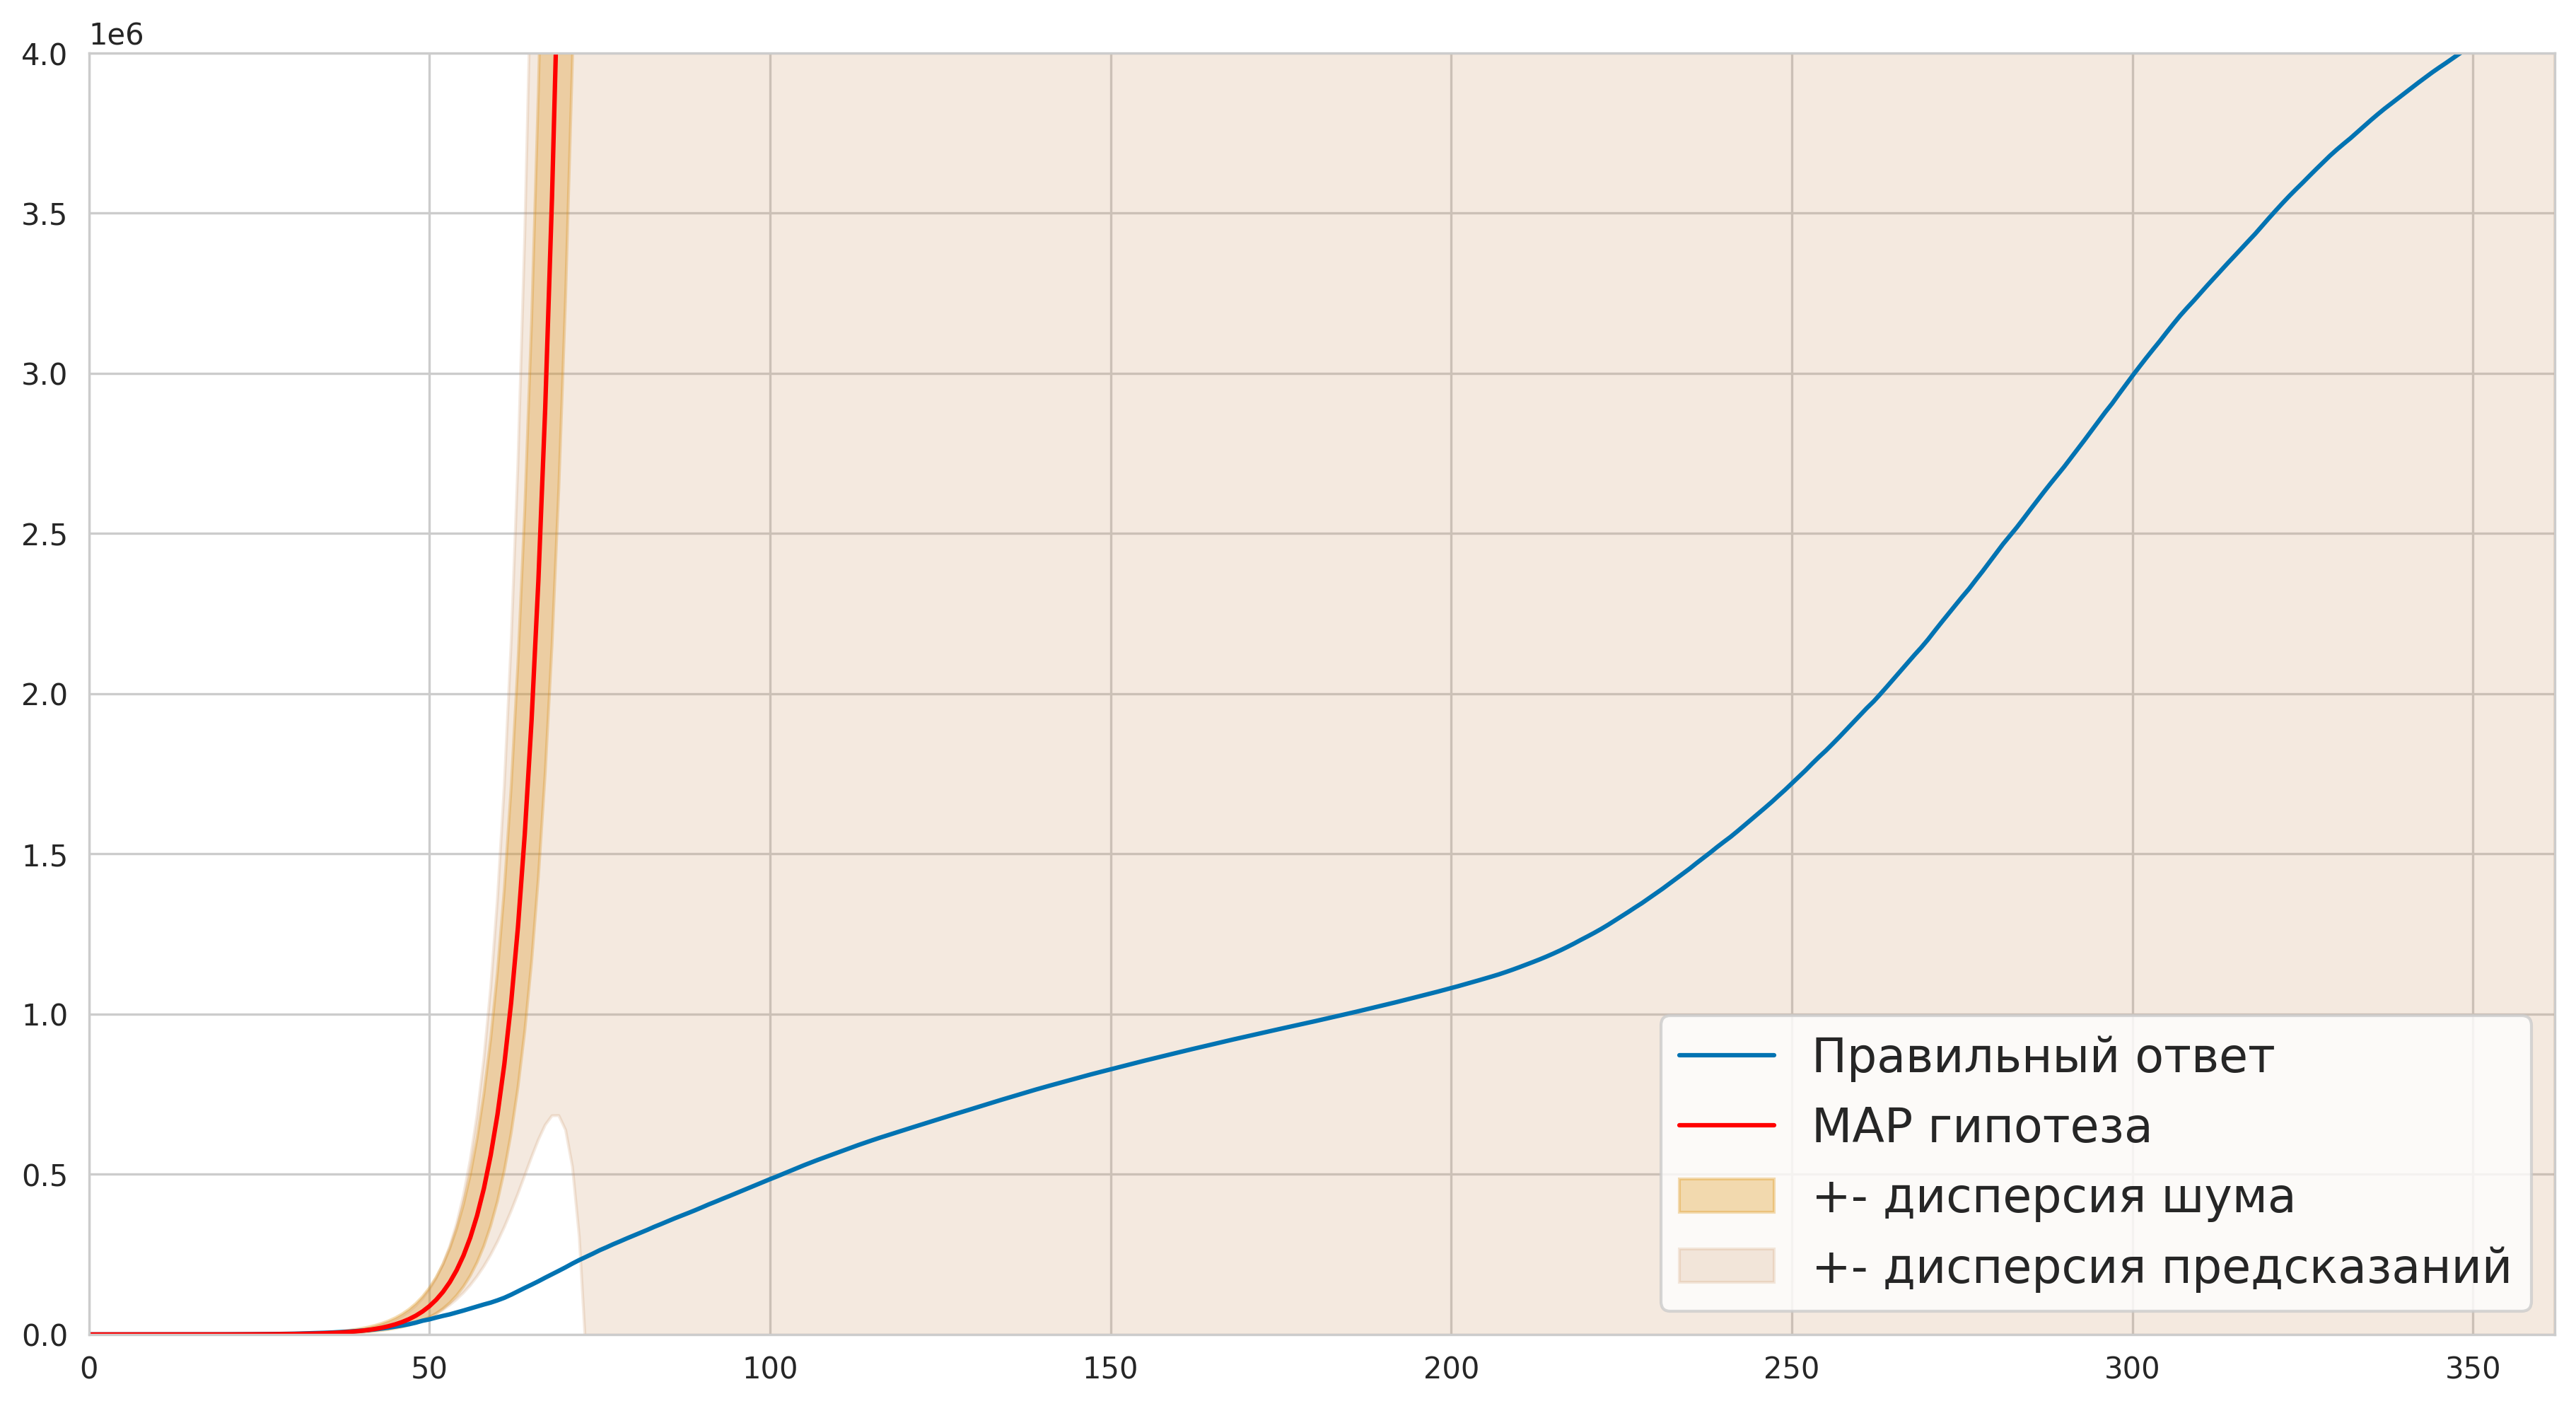

In [18]:
cur_mu_tc_exp, cur_sigma_tc_exp = np.array([total_cases_model.coef_[0], total_cases_model.intercept_]), \
                    np.array([[1, 0], [0, 1]])
for i in range(train.shape[0]):
    cur_mu_tc_exp, cur_sigma_tc_exp, total_cases_std = bayesian_update_exp(cur_mu_tc_exp, cur_sigma_tc_exp, train.days.values[i], \
                                                             np.log(train.total_cases.values[i]), total_cases_std, n=i)

x = sample_statistics_exp(cur_mu_tc_exp, cur_sigma_tc_exp, test.days.values, n=5000)
plot_predictions_exp(test.days.values, cur_mu_tc_exp, x, label='total_cases')

### c) 

Просэмплировав много разных экспонент, получили графики. По ним видно, что модель достаточно хорошо приближает только тренировочные данные. 

Посмотрим, сколько случаев модели бы предсказали к 1 мая/ июня/ сентября:

In [19]:
# new_cases

print(f'May, 1-st: {int(np.exp(cur_mu_nc_exp[1] * 60 + cur_mu_nc_exp[0]))} new cases')
print(f'June, 1-st: {int(np.exp(cur_mu_nc_exp[1] * 90 + cur_mu_nc_exp[0]))} new cases')
print(f'September, 1-st: {int(np.exp(cur_mu_nc_exp[1] * 180 + cur_mu_nc_exp[0]))} new cases')

May, 1-st: 29191 new cases
June, 1-st: 6554716 new cases
September, 1-st: 74209180067549 new cases


In [20]:
# total_cases

print(f'May, 1-st: {int(np.exp(cur_mu_tc_exp[1] * 60 + cur_mu_tc_exp[0]))} total cases')
print(f'June, 1-st: {int(np.exp(cur_mu_tc_exp[1] * 90 + cur_mu_tc_exp[0]))} total cases')
print(f'September, 1-st: {int(np.exp(cur_mu_tc_exp[1] * 180 + cur_mu_tc_exp[0]))} total cases')

May, 1-st: 686794 total cases
June, 1-st: 324382307 total cases
September, 1-st: 34178175953281752 total cases


## 3.

В данном пункте попробуем приблизить данные сигмоидой вида: 

$$ y = \int_{-\infty}^{x} e^{at^2 + bt + c}dt $$

Чтобы применить тут линейную регрессию, возьмем производную от обоих частей уравнения и прологарифмируем. Производную $y$ я представил в виде центральной разности соседних значений.

$$ ax^2 + bx + c = ln(\frac{y_{i+1} - y_{i-1}}{2}) $$

Теперь аналогично 2-му пункту задачи строим модель и графики.

In [37]:
def gauss_inv(df):
    a = df.copy()
    a['new_cases_next'] = a.new_cases.shift(-1, fill_value=a.new_cases.max())
    a['new_cases_prev'] = a.new_cases.shift(1, fill_value=a.new_cases.min())
    a['total_cases_next'] = a.total_cases.shift(-1, fill_value=a.total_cases.max())
    a['total_cases_prev'] = a.total_cases.shift(1, fill_value=a.total_cases.min())
    a['diff_new_cases'] = (a.new_cases_next - a.new_cases_prev) / 2
    a['diff_total_cases'] = (a.total_cases_next - a.total_cases_prev) / 2
    
    a['new_cases_gauss_inv'] = np.log(a.diff_new_cases.clip(lower=1e-13))
    a['total_cases_gauss_inv'] = np.log(a.diff_total_cases.clip(lower=1e-13))
    
    a['days^2'] = a.days ** 2
    return a.loc[:, ['days', 'days^2', 'new_cases', 'total_cases', 'new_cases_gauss_inv', 'total_cases_gauss_inv']]

In [38]:
train_df = gauss_inv(train)
test_df = gauss_inv(test)

In [39]:
def gauss_fit_predict(train_df, test_df):

    INF = - 10000
    h = 0.1
    
    new_cases_model = LinearRegression().fit(train_df[['days', 'days^2']], train_df['new_cases_gauss_inv'])
    total_cases_model = LinearRegression().fit(train_df[['days', 'days^2']], train_df['total_cases_gauss_inv'])
    
    new_cases_pred = new_cases_model.predict(train_df[['days', 'days^2']])
    total_cases_pred = total_cases_model.predict(train_df[['days', 'days^2']])
    new_cases_model_stats = {'coefs': np.array([1, new_cases_model.coef_[0], new_cases_model.coef_[1]]), 
                            'std': np.std(new_cases_pred - train_df.new_cases_gauss_inv)
                            }
    
    total_cases_model_stats = {'coefs': np.array([1, total_cases_model.coef_[0], total_cases_model.coef_[1]]), 
                            'std': np.std(total_cases_pred - train_df.total_cases_gauss_inv)
                            }
    
    list_of_days = test_df.days.to_list()
    last_day = test_df.days.max()
    points_for_integration = np.around(np.array([[t, t ** 2] for t in np.arange(INF, last_day + 1, h)]), 1)
    
    new_cases_prediction_gauss_inv = new_cases_model.predict(points_for_integration)
    total_cases_prediction_gauss_inv = total_cases_model.predict(points_for_integration)
    
    def integrate_gauss(arr):
        sum_ = 0
        ans = np.zeros(len(list_of_days))
        for i in range(points_for_integration.shape[0] - 1):
            sum_ += h * (np.exp(arr[i + 1]) + np.exp(arr[i])) / 2
            if points_for_integration[i][0] in list_of_days:
                ans[list_of_days.index(points_for_integration[i][0])] = sum_
        return ans
    
    a = test_df.copy()
    a['new_cases_prediction'] = integrate_gauss(new_cases_prediction_gauss_inv)
    a['total_cases_prediction'] = integrate_gauss(total_cases_prediction_gauss_inv)
    return a, new_cases_model_stats, total_cases_model_stats

In [40]:
gauss_df, new_cases_model_stats, total_cases_model_stats = gauss_fit_predict(train_df, test_df)

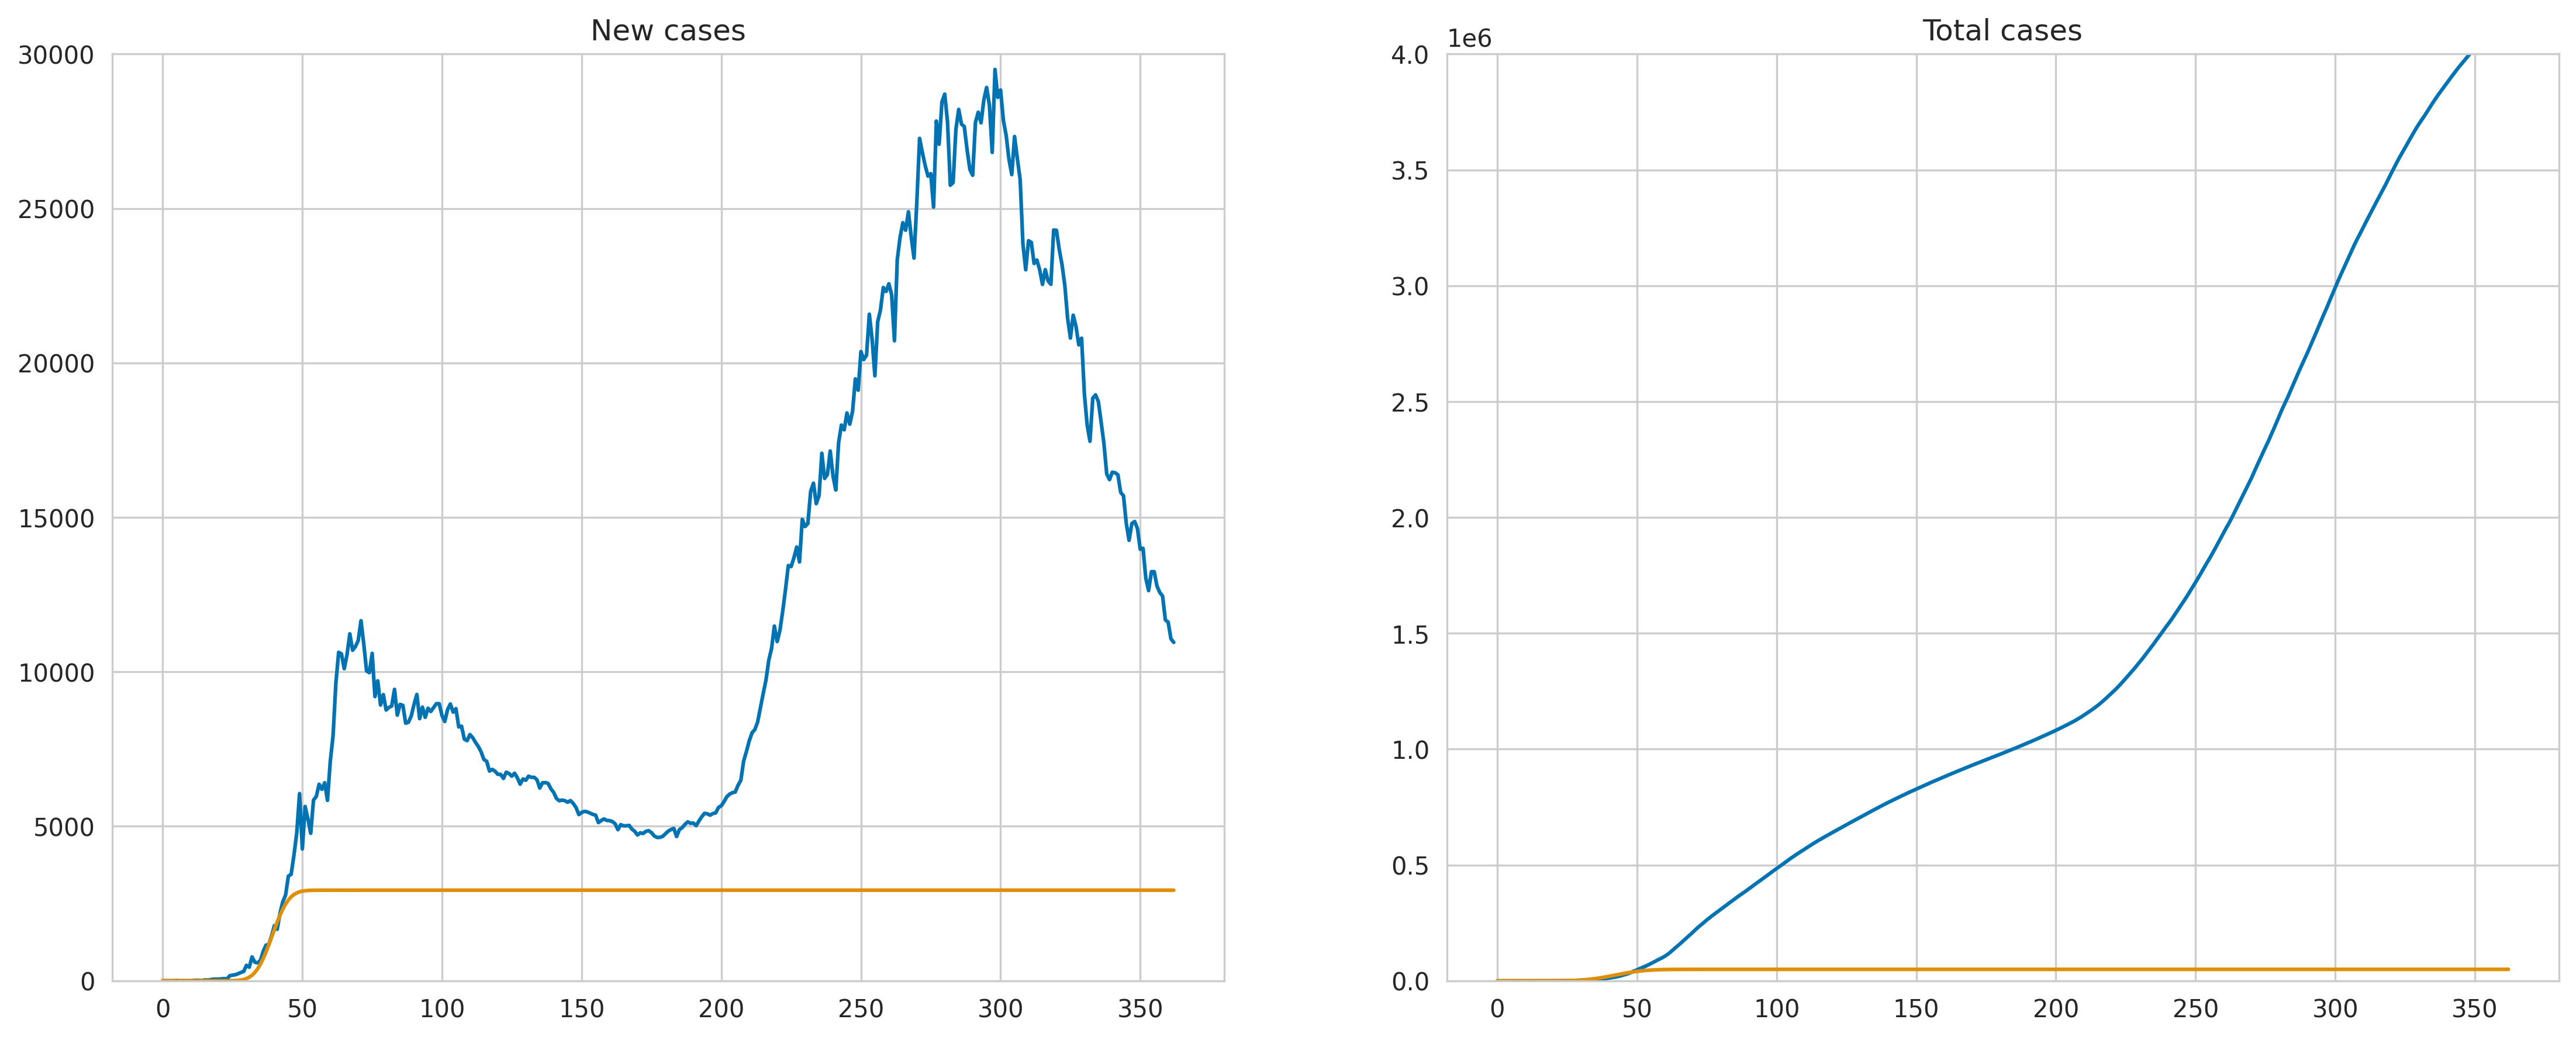

In [41]:
plt.figure(figsize=(18, 7))
plt.subplot(121)
plt.title('New cases')
plt.plot(gauss_df.days, gauss_df.new_cases)
plt.plot(gauss_df.days, gauss_df.new_cases_prediction)
plt.ylim((-2, 30000))

plt.subplot(122)
plt.title('Total cases')
plt.plot(gauss_df.days, gauss_df.total_cases)
plt.plot(gauss_df.days, gauss_df.total_cases_prediction)
plt.ylim((-2, 4e6))

plt.show()

In [42]:
def bayesian_update_gauss(mu, sigma, x, y, sigma_noise, n):
    if n != 0:
        sigma_noise = n/(n+1) * sigma_noise + 1/(n+1) * (y - mu[0] - mu[1] * x - mu[2] * x**2)**2
    x_matrix = np.array([[1, x, x**2]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n,
                     np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) 
                    )
    return mu_n, sigma_n, sigma_noise

In [43]:
def sample_statistics_gauss(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    INF = - 1000
    h = 0.1
    points_for_integration = np.around(np.array([[t, t**2] for t in np.arange(INF, xs[-1] + 1, h)]), 1)
    
    def integrate_gauss(arr):
        sum_ = 0
        ans = np.zeros(len(xs))
        for i in range(points_for_integration.shape[0] - 1):
            sum_ += h * (np.exp(arr[i + 1]) + np.exp(arr[i])) / 2
            if points_for_integration[i][0] in xs:
                ans[np.where(xs == points_for_integration[i][0])[0][0]] = sum_
        return ans

    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = integrate_gauss(w[2]*points_for_integration[:, 1] + w[1]*points_for_integration[:, 0] + w[0])
    return res

# Нарисуем результат
def plot_predictions_gauss(xs, mu, x, label='new_cases'):
    INF = - 10000
    h = 0.1
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    if label == 'new_cases':
        ax.set_ylim((-2, 30000))
    else:
        ax.set_ylim((-2, 3e6))
    points_for_integration = np.around(np.array([[t, t**2] for t in np.arange(INF, xs[-1] + 1, h)]), 1)
    
    def integrate_gauss(arr):
        sum_ = 0
        ans = np.zeros(len(xs))
        for i in range(points_for_integration.shape[0] - 1):
            sum_ += h * (np.exp(arr[i + 1]) + np.exp(arr[i])) / 2
            if points_for_integration[i][0] in xs:
                ans[np.where(xs == points_for_integration[i][0])[0][0]] = sum_
        return ans
    
    ys = integrate_gauss(mu[2]*points_for_integration[:, 1] + mu[1]*points_for_integration[:, 0] + mu[0])
    ys_bottom = integrate_gauss(mu[2]*points_for_integration[:, 1] + mu[1]*points_for_integration[:, 0] + mu[0] + 0.5)
    ys_top = integrate_gauss(mu[2]*points_for_integration[:, 1] + mu[1]*points_for_integration[:, 0] + mu[0] - 0.5)
    
    
    
    ax.plot(xs, test[label], label="Правильный ответ")
    ax.plot(xs, ys, color="red", label="MAP гипотеза")
    ax.fill_between(xs, ys_bottom, ys_top, color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), 
                    np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend(fontsize=legend_fontsize)

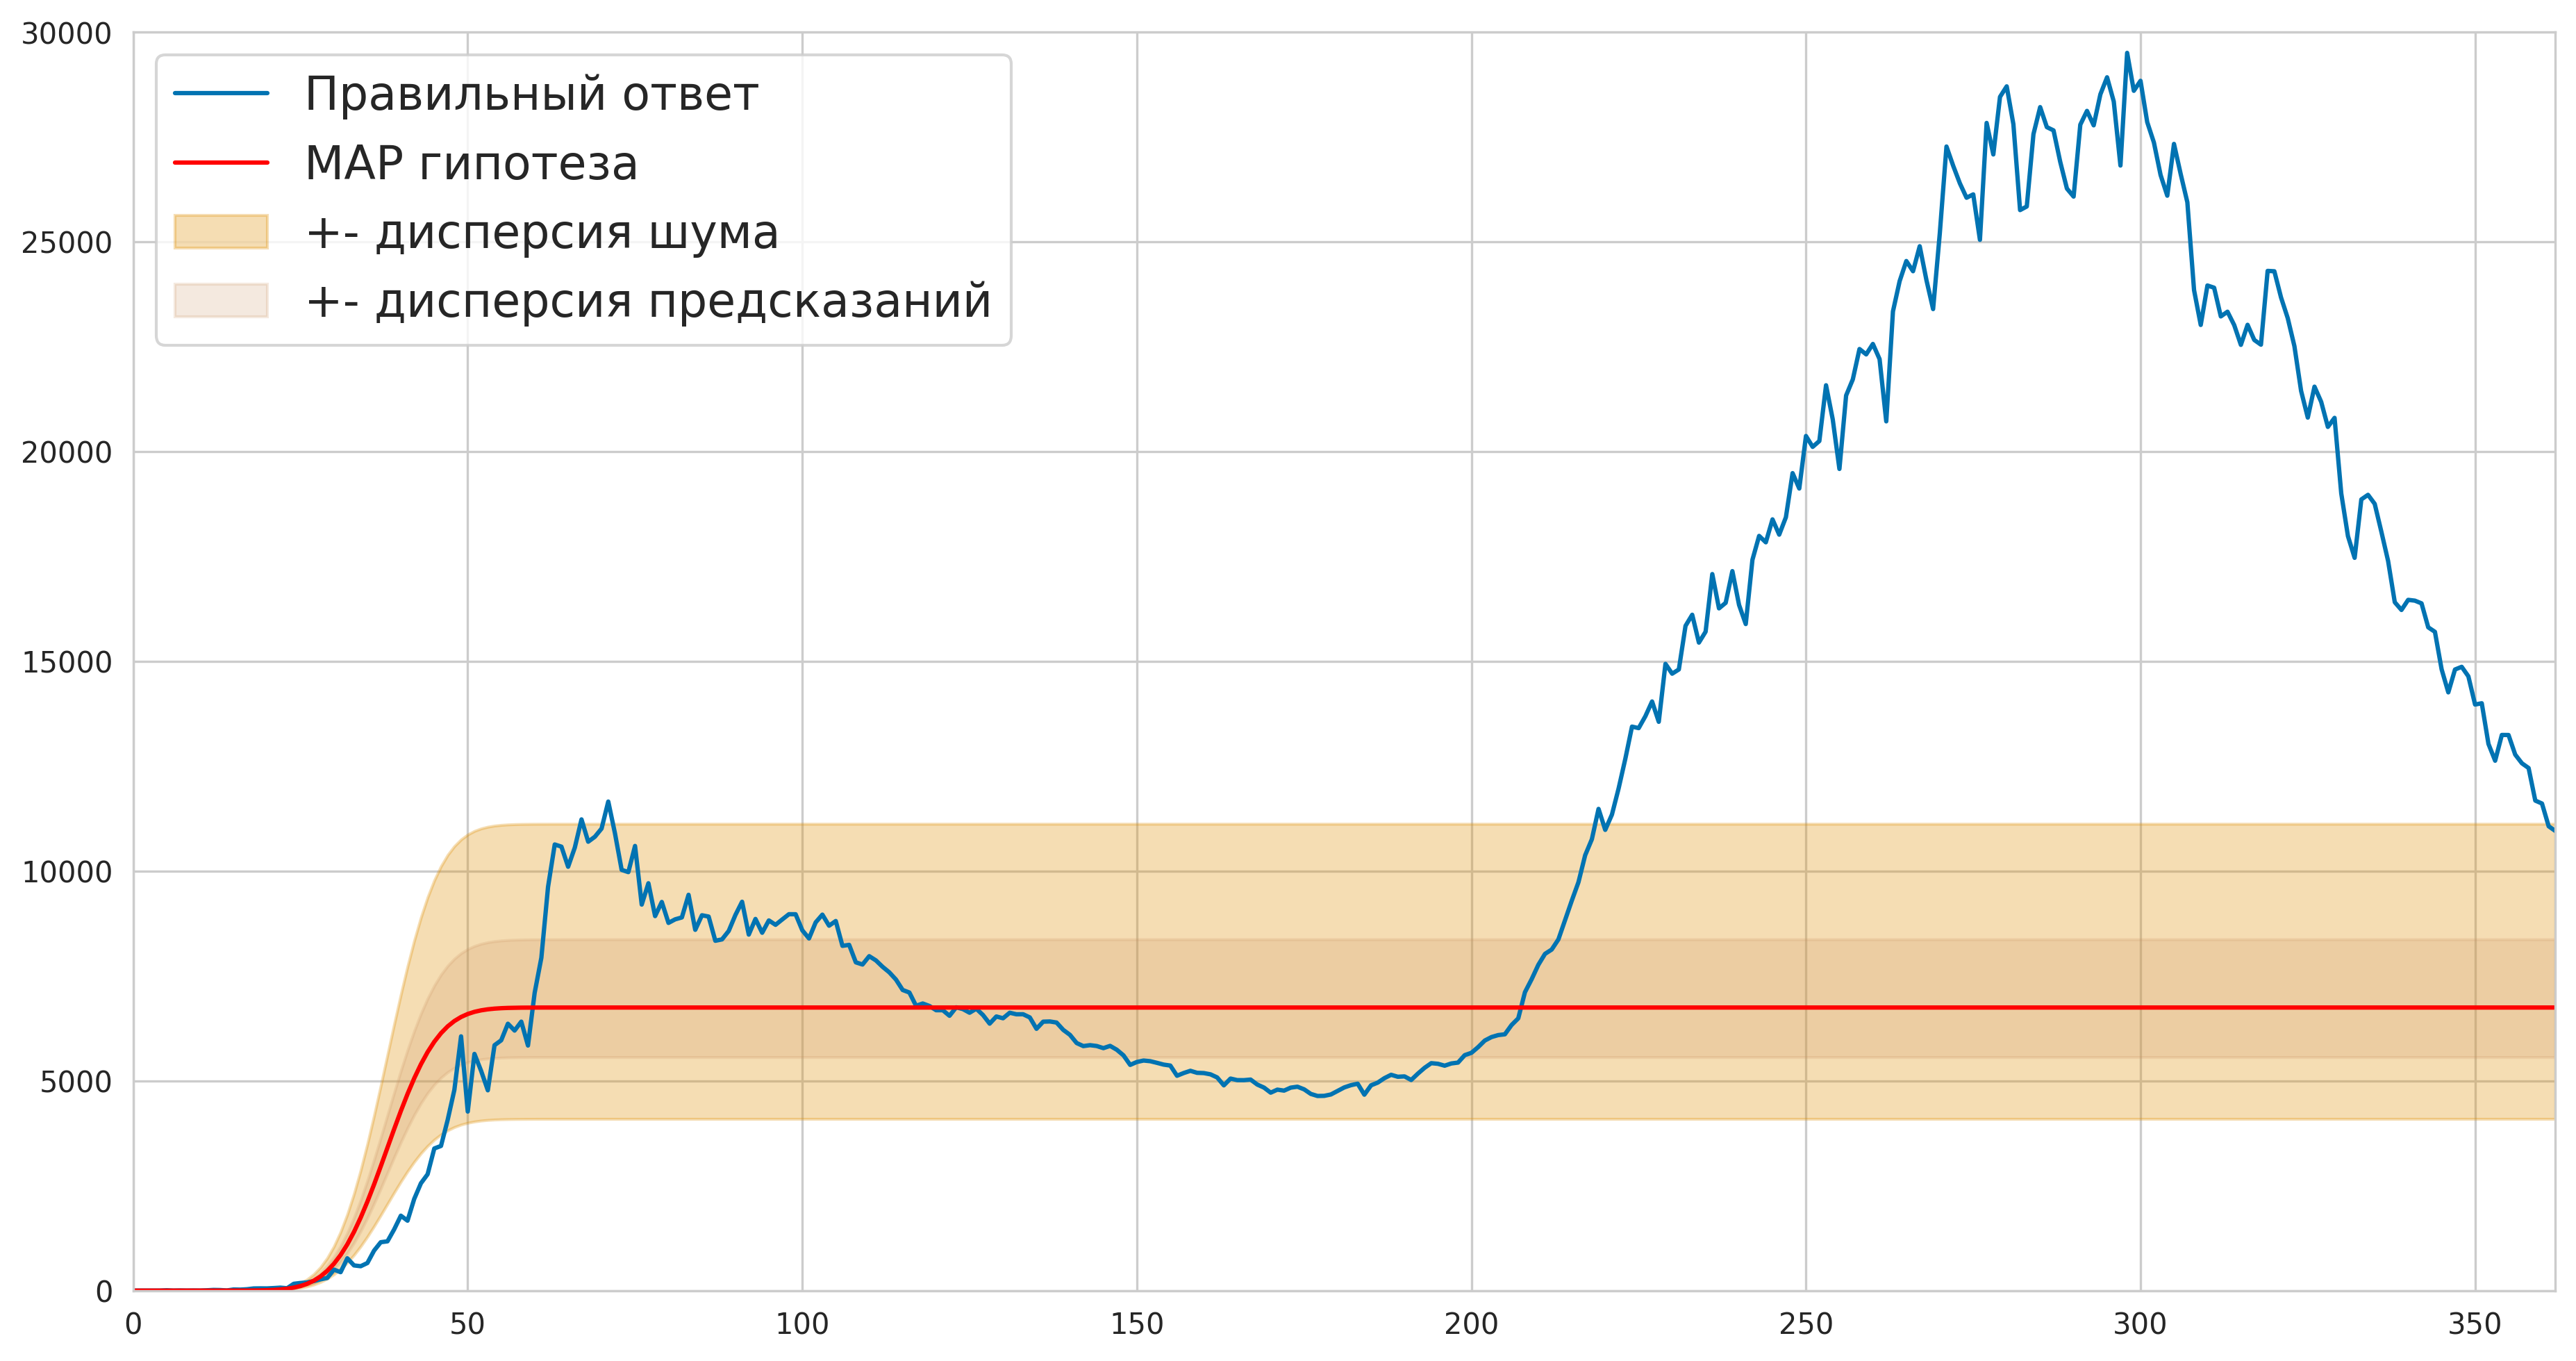

In [50]:
cur_mu_nc_gauss, cur_sigma_nc_gauss = new_cases_model_stats['coefs'], np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
new_cases_sigma_noise = new_cases_model_stats['std'] ** 2

for i in range(train.shape[0]):
    cur_mu_nc_gauss, cur_sigma_nc_gauss, new_cases_sigma_noise = bayesian_update_gauss(cur_mu_nc_gauss, cur_sigma_nc_gauss, train_df.days.values[i], 
                                              train_df.new_cases_gauss_inv.values[i], 0.9, i)

x = sample_statistics_gauss(cur_mu_nc_gauss, cur_sigma_nc_gauss, test_df.days.values, n=1000)
plot_predictions_gauss(test_df.days.values, cur_mu_nc_gauss, x)

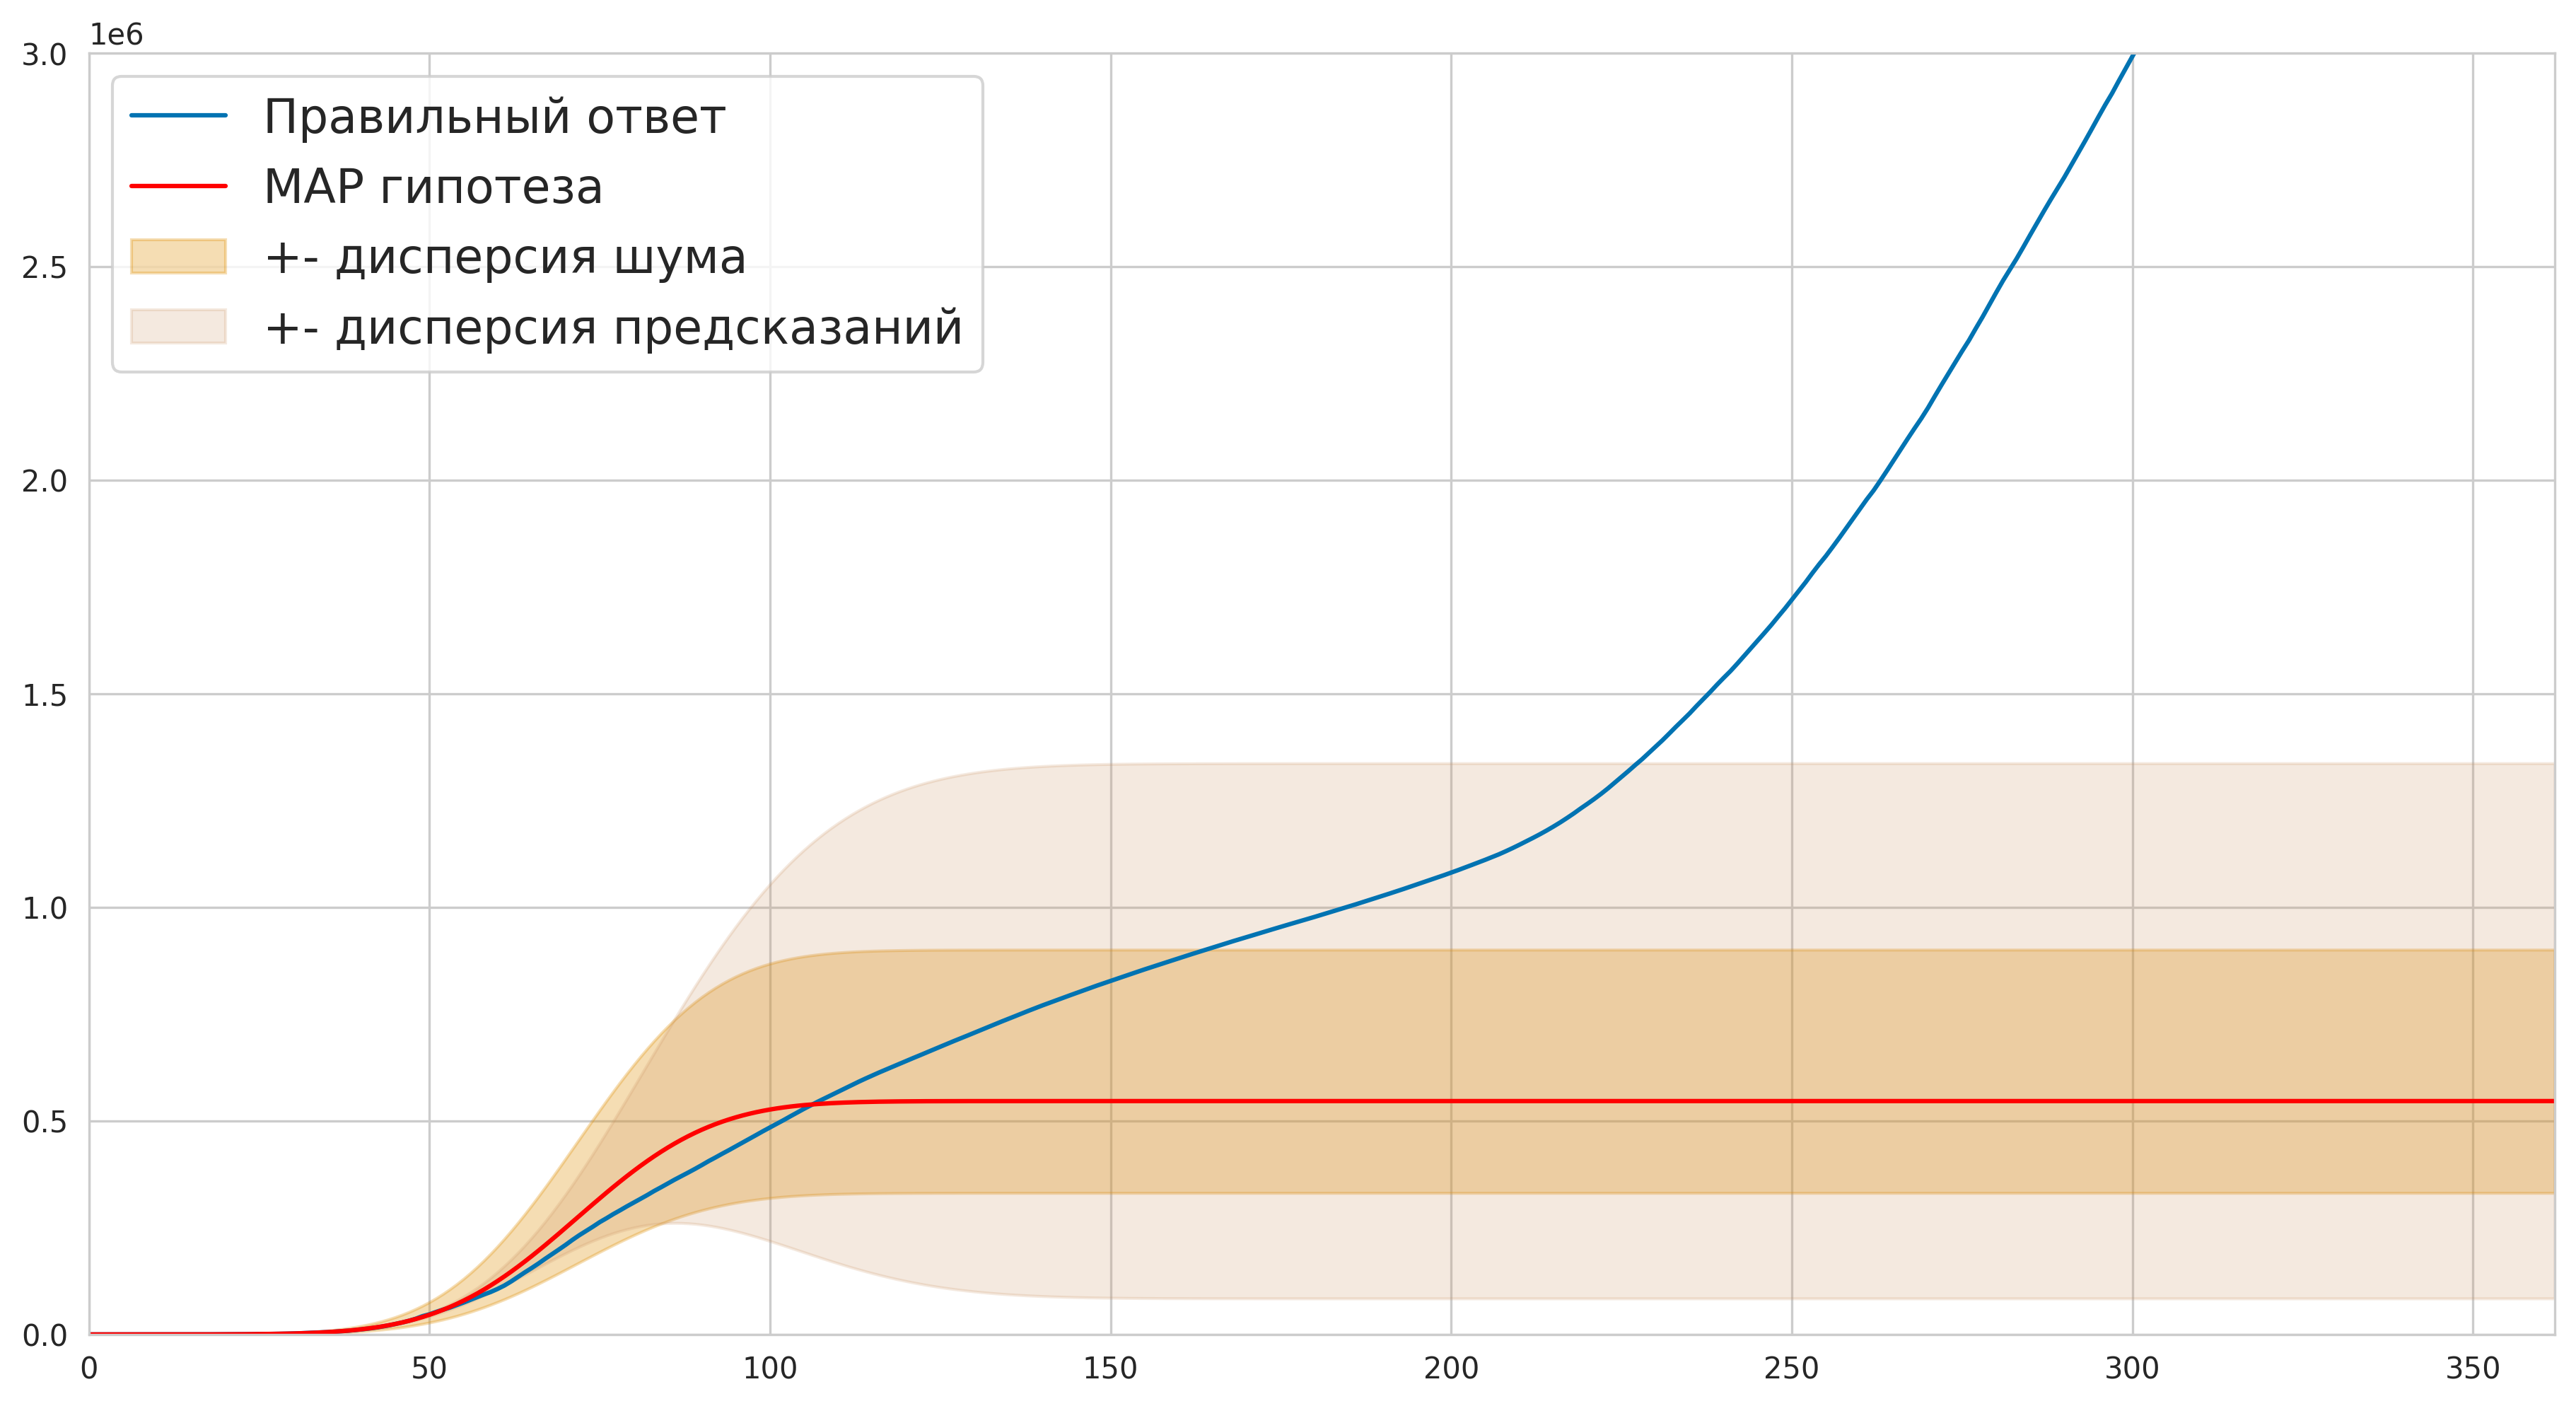

In [48]:
cur_mu_tc_gauss, cur_sigma_tc_gauss = total_cases_model_stats['coefs'], np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
total_cases_sigma_noise = total_cases_model_stats['std'] ** 2

for i in range(train.shape[0]):
    cur_mu_tc_gauss, cur_sigma_tc_gauss, total_cases_sigma_noise = bayesian_update_gauss(cur_mu_tc_gauss, cur_sigma_tc_gauss, train_df.days.values[i], 
                                              train_df.total_cases_gauss_inv.values[i], 0.3, i)

x = sample_statistics_gauss(cur_mu_tc_gauss, cur_sigma_tc_gauss, test_df.days.values, n=1000)
plot_predictions_gauss(test_df.days.values, cur_mu_tc_gauss, x, label='total_cases')

Получили гораздо лучшие модели по сравнению с экспоненциальной моделью. Видно, что 

In [49]:
print(f' Предсказание модели для пессимистичного сценария - {int(np.mean(x, axis=0)[-1] + np.std(x, axis=0)[-1] * 0.9)} человек')
print(f' Предсказание модели для оптимистичного сценария - {int(np.mean(x, axis=0)[-1] - np.std(x, axis=0)[-1] * 0.9)} человек')

 Предсказание модели для пессимистичного сценария - 1274422 человек
 Предсказание модели для оптимистичного сценария - 146950 человек
